In [ ]:
!pip install bt

In [ ]:
!pip install yfinance

In [3]:
import bt
import yfinance as yf
import pandas as pd
import matplotlib

matplotlib.style.use("seaborn-darkgrid")
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
<ipython-input-3-cfbd08e70d4d>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-darkgrid")


# Funcoes

In [4]:
def consulta_bc(codigo_bcb):

    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)

    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)

    df.set_index('data', inplace=True)

    return df

def cdi_acumulado(data_inicio, data_fim):

    cdi = consulta_bc(12)

    cdi_acumulado = (1 + cdi[data_inicio:data_fim] / 100).cumprod()
    cdi_acumulado.iloc[0] = 1

    return cdi_acumulado


In [5]:
inicio = "2018-01-01"
fim = "2023-12-31"

In [6]:
cdi = cdi_acumulado(data_inicio=inicio,data_fim=fim)

In [7]:
ativos = ["BPAC11.SA","ITUB3.SA","VALE3.SA","EGIE3.SA","WEGE3.SA"]

carteira = yf.download(ativos,start=inicio,end=fim)["Adj Close"]

[*********************100%%**********************]  5 of 5 completed


In [8]:
carteira["Renda Fixa"] = cdi
carteira.dropna(inplace=True)

In [9]:
carteira

Ticker,BPAC11.SA,EGIE3.SA,ITUB3.SA,VALE3.SA,WEGE3.SA,Renda Fixa
Date,,,,,,
2018-01-02,3.879361,19.145195,18.409050,27.350491,8.752858,1.000000
2018-01-03,3.916308,19.016563,18.552576,27.186594,8.619920,1.000529
2018-01-04,3.930676,18.770012,18.758282,27.298042,8.535961,1.000794
2018-01-05,3.995665,18.866488,18.887459,27.724165,8.570946,1.001058
2018-01-08,4.044626,18.973684,18.782200,28.340406,8.640908,1.001323
...,...,...,...,...,...,...
2023-12-21,36.511269,44.422287,27.029528,76.970001,36.088661,1.533895
2023-12-22,36.650700,44.570000,27.241222,76.389999,36.207664,1.534566
2023-12-26,37.138714,44.790001,27.558762,76.660004,36.415928,1.535237


# Backtesting


In [10]:

rebalanceamento = bt.Strategy('rebalanceamento',
                                [bt.algos.RunMonthly(run_on_end_of_period=True),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])


In [11]:
buy_hold = bt.Strategy('Buy&Hold',
                            [bt.algos.RunOnce(),
                             bt.algos.SelectAll(),
                             bt.algos.WeighEqually(),
                             bt.algos.Rebalance()])

In [12]:
    # Realiza o backtest das duas estratégias
bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_hold, carteira[["BPAC11.SA","ITUB3.SA","VALE3.SA","EGIE3.SA","WEGE3.SA"]])

In [13]:
    # Obtém os resultados do backtest
resultados = bt.run(bt1, bt2)

# Resultados


In [14]:
resultados.display()

Stat                 rebalanceamento    Buy&Hold
-------------------  -----------------  ----------
Start                2018-01-01         2018-01-01
End                  2023-12-28         2023-12-28
Risk-free rate       0.00%              0.00%

Total Return         247.80%            310.70%
Daily Sharpe         1.15               1.00
Daily Sortino        1.84               1.59
CAGR                 23.14%             26.61%
Max Drawdown         -31.84%            -43.93%
Calmar Ratio         0.73               0.61

MTD                  5.59%              6.52%
3m                   13.49%             15.97%
6m                   14.37%             17.59%
YTD                  21.56%             26.22%
1Y                   20.98%             24.96%
3Y (ann.)            10.56%             10.22%
5Y (ann.)            23.65%             27.54%
10Y (ann.)           -                  -
Since Incep. (ann.)  23.14%             26.61%

Daily Sharpe         1.15               1.00
Daily Sor

<Axes: title={'center': 'Equity Progression'}>

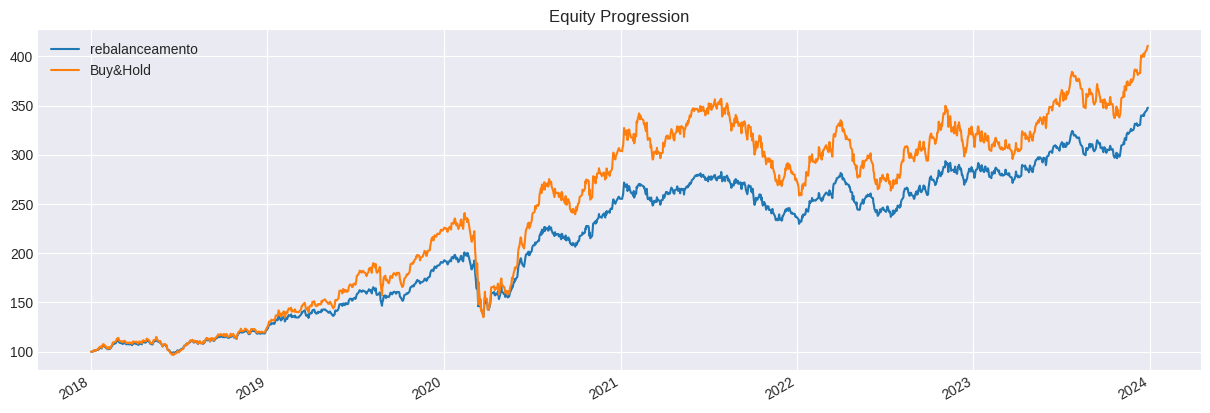

In [15]:
resultados.plot()

In [16]:
resultados.get_transactions()

price  quantity
Date       Security                       
2018-01-02 BPAC11.SA    3.879361   42962.0
           EGIE3.SA    19.145195    8705.0
           ITUB3.SA    18.409050    9053.0
           Renda Fixa   1.000000  166666.0
           VALE3.SA    27.350491    6093.0
...                          ...       ...
2023-11-30 EGIE3.SA    43.326672     -56.0
           ITUB3.SA    25.495802   -1499.0
           Renda Fixa   1.523624   30359.0
           VALE3.SA    73.849998     142.0
           WEGE3.SA    33.839176     975.0

[431 rows x 2 columns]

In [17]:
resultados.get_security_weights()

,BPAC11.SA,EGIE3.SA,ITUB3.SA,VALE3.SA,WEGE3.SA,Renda Fixa
2018-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-02,0.166665,0.166659,0.166657,0.166647,0.166663,0.166666
2018-01-03,0.168535,0.165817,0.168238,0.165926,0.164407,0.167034
2018-01-04,0.169245,0.163756,0.170196,0.166697,0.162894,0.167169
2018-01-05,0.170656,0.163271,0.169987,0.167934,0.162244,0.165865
...,...,...,...,...,...,...
2023-12-21,0.166421,0.164324,0.169913,0.167036,0.170922,0.161355
2023-12-22,0.166742,0.164560,0.170921,0.165464,0.171163,0.161122
2023-12-26,0.167844,0.164277,0.171768,0.164950,0.171007,0.160125
2023-12-27,0.168043,0.164930,0.171690,0.165541,0.170535,0.159232


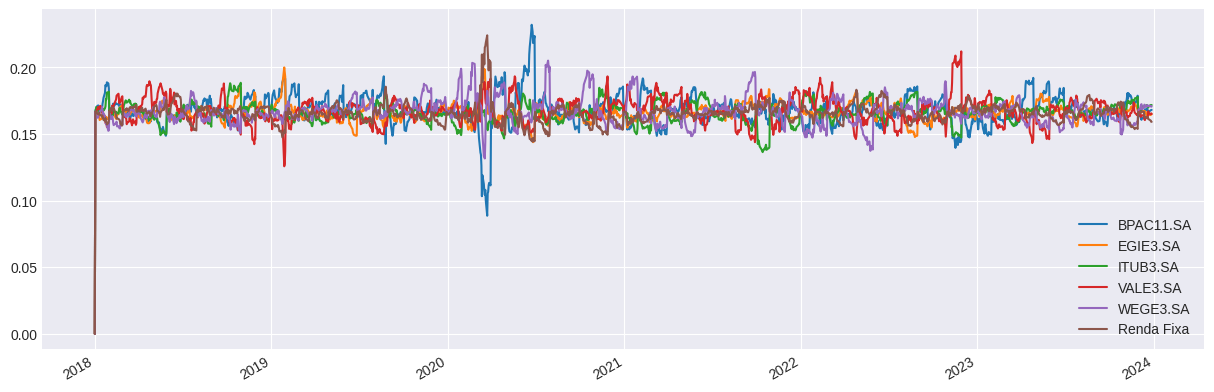

In [18]:
resultados.plot_security_weights()